# Submission Group Assignment Network Science HS22

Participants:

    Alexander Christian Lerch, 17-678-111
    Diego Ricardo Bugmann, 18-472-548
    Szymon Kaczmarski, 21-743-778      

### LIBRARIES & DATASET

In [69]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sp
import networkx.algorithms.community as nxcom
from matplotlib import colors as mcolors
import powerlaw
from scipy.special import factorial
import pandas as pd
from tabulate import tabulate
import time
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
from tqdm import tqdm
import pickle

In [95]:
# -------------------P A T H S---------------------------
PATH_TWITCH_DE = 'dataset//DE//musae_DE_edges.csv'
PATH_TWITCH_EN = 'dataset//ENGB//musae_ENGB_edges.csv'
PATH_TWITCH_RU = 'dataset//RU//musae_RU_edges.csv'

# ----------------D A T A R E A D -----------------------
with open(PATH_TWITCH_DE, 'rb') as twitch:
    next(twitch, '')   # skip a line
    G_TWITCH_DE = nx.read_edgelist(twitch, delimiter=',', 
                                    create_using=nx.Graph(), 
                                    nodetype=int, encoding="utf-8")
with open(PATH_TWITCH_EN, 'rb') as twitch:
    next(twitch, '')   # skip a line
    G_TWITCH_EN = nx.read_edgelist(twitch, delimiter=',', 
                                    create_using=nx.Graph(), 
                                    nodetype=int, encoding="utf-8")
with open(PATH_TWITCH_RU, 'rb') as twitch:
    next(twitch, '')   # skip a line
    G_TWITCH_RU = nx.read_edgelist(twitch, delimiter=',', 
                                    create_using=nx.Graph(), 
                                    nodetype=int, encoding="utf-8")

# ---------------------S U M M A R Y ----------------------
datasets = [G_TWITCH_DE, G_TWITCH_EN, G_TWITCH_RU]
print(PATH_TWITCH_DE, ' : ', G_TWITCH_DE)
print(PATH_TWITCH_EN, ' : ', G_TWITCH_EN)
print(PATH_TWITCH_RU, ' : ', G_TWITCH_RU)

dataset//DE//musae_DE_edges.csv  :  Graph with 9498 nodes and 153138 edges
dataset//ENGB//musae_ENGB_edges.csv  :  Graph with 7126 nodes and 35324 edges
dataset//RU//musae_RU_edges.csv  :  Graph with 4385 nodes and 37304 edges


In [19]:
PATH_TWITCH_FEATURES_DE = 'dataset//DE//musae_DE_target.csv'
PATH_TWITCH_FEATURES_EN = 'dataset//ENGB//musae_ENGB_target.csv'
PATH_TWITCH_FEATURES_RU = 'dataset//RU//musae_RU_target.csv'
df_features_de = pd.read_csv(PATH_TWITCH_FEATURES_DE, sep=',', header=0, index_col=0)
df_features_en = pd.read_csv(PATH_TWITCH_FEATURES_EN, sep=',', header=0, index_col=0)
df_features_ru = pd.read_csv(PATH_TWITCH_FEATURES_RU, sep=',', header=0, index_col=0)

# ALGORITHMS

In [72]:
ALGORITHMS_NAMES = ['Degree Centrality', 'K-Shell', 'Betweenness Centrality', 'VoteRank', 'PageRank', 'Closeness Centrality', 'Eigenvector Centrality', 'H-Index']

In [101]:
# --------------------- H - i n d e x ----------------------
# https://www.geeksforgeeks.org/what-is-h-index/
def h_index_for_node(G, n):
    # sorting in ascending order
    neighbour_degrees_sorted = sorted((G.degree(v) for v in G.neighbors(n))) 
    # iterating over the list
    for i, node_degree in enumerate(neighbour_degrees_sorted):
        # finding current result
        result = len(neighbour_degrees_sorted) - i
        # if result is less than or equal
        # to node_degree then return result
        if result <= node_degree:
            return result
    return 0

def h_index(G):
    hindex_list = {}
    for n in G.nodes():
        hindex_list[n] = h_index_for_node(G, n)
    return hindex_list

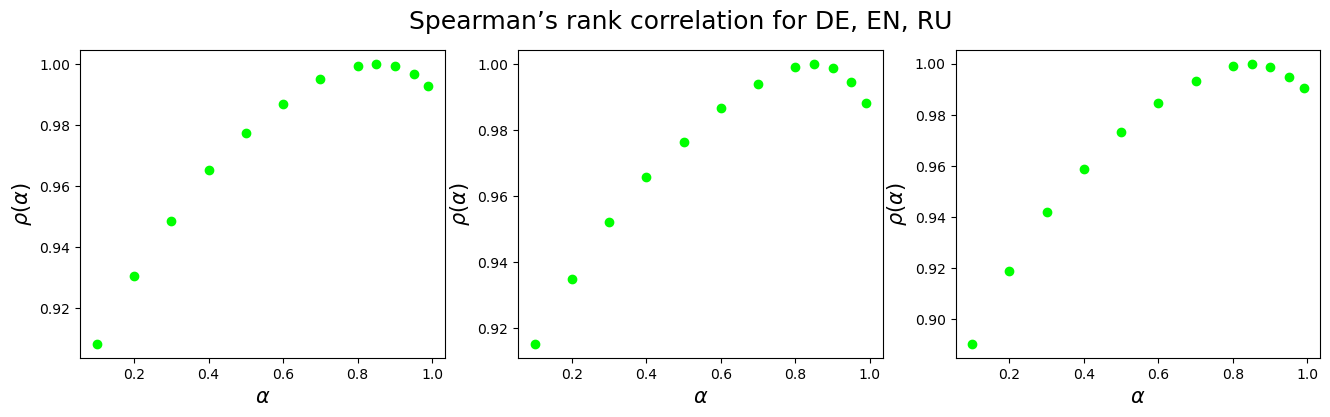

In [109]:
# Compute Spearman’s rank correlation 𝜌 between the PageRanks for 𝛼_0 = 0.85 and all other 𝛼_s
from scipy.stats import spearmanr
fig = plt.figure(figsize=(16, 4))
# set figure title
fig.suptitle("Spearman’s rank correlation for DE, EN, RU", size=18)
i = 1
for dataset in datasets:
    pr_alpha_0 = list(nx.pagerank(dataset, alpha=0.85).values())
    alpha_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 0.99]
    # compute pagerank & spearman correlation for each alpha:
    pageranks = {}
    spearman_correlations = {}
    for alpha in alpha_values:
        pageranks[alpha] = list(nx.pagerank(dataset, alpha=alpha).values())
        spearman_correlations[alpha] = spearmanr(pr_alpha_0, pageranks[alpha])[0]
    ax=fig.add_subplot(1,3,i)
    ax.scatter(spearman_correlations.keys(), spearman_correlations.values(), color = "lime")
    ax.set_xlabel(r"$\alpha$", fontsize=15)
    ax.set_ylabel(r"$\rho(\alpha)$", fontsize=15)
    i += 1
fig.subplots_adjust(hspace=3.5)
plt.show()

In [90]:
def voterank_return_dict(G):
    '''
        [create a dict with value for each node]
        assign max_value to the first node in result_voterank
        assign max_value - 1 to the second node in result_voterank
        ...
        assign -1 to the nodes that are not in result_voterank
    '''
    result_voterank = nx.voterank(G)
    dict_voterank = {}
    max_value = len(G.nodes)
    i = 0
    while i < len(result_voterank):
        dict_voterank[result_voterank[i]] = max_value
        max_value -= 1
        i += 1
    for n in G.nodes:
        if n not in dict_voterank:
            dict_voterank[n] = -1
    return dict_voterank

In [91]:
def run_algorithms(G):
    pbar = tqdm(total=len(ALGORITHMS_NAMES))
    results = []
    results.append(nx.degree_centrality(G)) # returns dict
    pbar.update(1)
    # k_shell - mark nodes in outer shell as 1, others as 0
    # outer_shell_nodes = list(nx.k_shell(G).nodes)
    # k_shell = [1 if node in outer_shell_nodes else 0 for node in G.nodes]
    core_number = nx.core_number(G) # returns dict
    results.append(core_number)
    pbar.update(1)
    results.append(nx.betweenness_centrality(G, k=None, normalized=True, weight=None, seed=123)) # returns dict
    pbar.update(1)

    # results.append(nx.voterank(G)) # BUG returns list - Ordered list of computed seeds. Only nodes with positive number of votes are returned.
    results.append(voterank_return_dict(G)) # returns dict

    pbar.update(1)
    results.append(nx.pagerank(G, alpha=0.85, max_iter=100, tol=1e-06, weight=None)) # returns dict
    pbar.update(1)
    results.append(nx.closeness_centrality(G)) # returns dict
    pbar.update(1)
    results.append(nx.eigenvector_centrality(G, max_iter=100, tol=1e-06)) # returns dict
    pbar.update(1)
    results.append(h_index(G)) # returns dict
    pbar.update(1)
    pbar.close()
    for i in range(len(results)):
        if len(results[i]) != len(G.nodes):
            print('ERROR - results for ',ALGORITHMS_NAMES[i], ' is not the same length as G.nodes')
    return results

In [ ]:
# run for each language
results_de = run_algorithms(G_TWITCH_DE)
results_en = run_algorithms(G_TWITCH_EN)
results_ru = run_algorithms(G_TWITCH_RU)
# save the results in results folder as pickle
with open('results//results_de.pickle', 'wb') as handle:
    pickle.dump(results_de, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('results//results_en.pickle', 'wb') as handle:
    pickle.dump(results_en, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('results//results_ru.pickle', 'wb') as handle:
    pickle.dump(results_ru, handle, protocol=pickle.HIGHEST_PROTOCOL)
# save names of algorithms
with open('results//algorithms_names.pickle', 'wb') as handle:
    pickle.dump(ALGORITHMS_NAMES, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# load the results
with open('results//results_de.pickle', 'rb') as handle:
    results_de = pickle.load(handle)
with open('results//results_en.pickle', 'rb') as handle:
    results_en = pickle.load(handle)
with open('results//results_ru.pickle', 'rb') as handle:
    results_ru = pickle.load(handle)
# load names of algorithms
with open('results//algorithms_names.pickle', 'rb') as handle:
    ALGORITHMS_NAMES = pickle.load(handle)

In [112]:
G = G_TWITCH_DE
# k-shell only returns the nodes from the outer shell
outer_shell_nodes = list(nx.k_shell(G).nodes)
k_shell = [1 if node in outer_shell_nodes else 0 for node in G.nodes]


core_number = nx.core_number(G) # returns dict

In [116]:
# print distinct values of core_number
print(set(core_number.values()))

# get the nodes that have highest core number
max_core_number = max(core_number.values())
nodes_with_max_core_number = [node for node, core_number in core_number.items() if core_number == max_core_number]
print("Lenght nodes with max core: ", len(nodes_with_max_core_number))

# check if result from k-shell is the same as nodes with max core number
print(set(nodes_with_max_core_number) == set(outer_shell_nodes))	

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43}
Lenght nodes with max core:  350
True


In [126]:
# get keys of core_number
core_number_keys = list(core_number.keys())
print("Lenght core_number_keys: ", len(core_number_keys))
# get unique values for keys
core_number_keys_unique = list(set(core_number_keys))
print("Lenght core_number_keys_unique: ", len(core_number_keys_unique))


Lenght core_number_keys:  9498
Lenght core_number_keys_unique:  9498


In [148]:
def calculate_k_shell(G):
    k_shell_nodes_for_shell = {}
    N = 100
    pbar = tqdm(total=N)
    for i in range(1,N):
        list_of_nodes = list(nx.k_shell(G, k = i).nodes)
        if list_of_nodes:
            k_shell_nodes_for_shell[i] = list_of_nodes
            pbar.update(1)
        else:
            print(f"Completed at {i-1}. All nodes removed.")
            pbar.update(N-i+1)
            break
    pbar.close()

    k_shell = {}
    for shell, list_of_nodes_per_shell in k_shell_nodes_for_shell.items():
        for node in list_of_nodes_per_shell:
            k_shell[node] = shell

    return k_shell

In [149]:
k_shell = calculate_k_shell(G_TWITCH_DE)

100%|██████████| 100/100 [00:51<00:00,  1.93it/s]

Completed at 43. All nodes removed.


In [151]:
# print the nodes with the hisghest value in k_shell
max_k_shell = max(k_shell.values())
nodes_with_max_k_shell = [node for node, k_shell in k_shell.items() if k_shell == max_k_shell]
print("Lenght nodes with max k_shell: ", len(nodes_with_max_k_shell))
# print the nodes with the hisghest value in core_number
max_core_number = max(core_number.values())
nodes_with_max_core_number = [node for node, core_number in core_number.items() if core_number == max_core_number]
print("Lenght nodes with max core: ", len(nodes_with_max_core_number))

# check if result from k-shell is the same as nodes with max core number
print(set(nodes_with_max_core_number) == set(nodes_with_max_k_shell))

Lenght nodes with max k_shell:  350
Lenght nodes with max core:  350
True


In [132]:
# check if each node appearas only once
k_shell_nodes_dict_count = {}
for shell, list_of_nodes_per_shell in k_shell_nodes.items():
    for node in list_of_nodes_per_shell:
        if node in k_shell_nodes_dict_count:
            k_shell_nodes_dict_count[node] += 1
        else:
            k_shell_nodes_dict_count[node] = 1

# get keys of core_number
k_shell_nodes_dict_count_keys = list(k_shell_nodes_dict_count.keys())
print("Lenght kshell_keys: ", len(k_shell_nodes_dict_count_keys))
# get unique values for keys
core_number_keys_unique = list(set(k_shell_nodes_dict_count_keys))
print("Lenght kshell_keys_unique: ", len(core_number_keys_unique))

Lenght kshell_keys:  9498
Lenght kshell_keys_unique:  9498


In [134]:
# value for each node, node = key
k_shell_FINAL = {}
for shell, list_of_nodes_per_shell in k_shell_nodes.items():
    for node in list_of_nodes_per_shell:
        k_shell_FINAL[node] = shell

# get the nodes that have highest core number
max_k_shell_FINAL = max(k_shell_FINAL.values())
nodes_with_max_kshell = [node for node, k_shell_value in k_shell_FINAL.items() if k_shell_value == max_k_shell_FINAL]
print("Lenght nodes with max core: ", len(nodes_with_max_kshell))

Lenght nodes with max core:  350


In [147]:
 # check if they have the same values 
for node, value in k_shell.items():
    if node in core_number:
        if core_number[node] != value:
            print("ERROR - core_number[node] != value")
    else:
        print("ERROR - node not in core_number")

# SIR (Susceptible-Infected-Recovered) model

In [87]:
# method to calculate the infected scale
def get_infected_scale(infected, recovered, total):
    return (infected + recovered) / total

# method to plot values
def plot_values(x, y, title):
    plt.plot(x, y)
    plt.ylabel("F(t)")
    plt.xlabel("t")
    plt.title(title)
    plt.show()

# method to get beta
def get_beta(network):
    beta_threshold = get_infection_threshold(network)
    return 1.5 * beta_threshold
    
# method to get the infection threshold
def get_infection_threshold(network):
    degrees = [v for k,v in network.degree()]
    avg_degree = np.mean(degrees)
    avg_sqrd_degrees = np.mean([d**2 for d in degrees])
    bth = avg_degree / (avg_sqrd_degrees - avg_degree)
    return bth

# method to get gamma
def get_gamma(network):
    degrees = [v for k,v in network.degree()]
    avg_degree = np.mean(degrees)
    return 2 / avg_degree

In [91]:
# method to simulate a model
def simulate(network, p, beta=None, gamma=None, num_of_simulations=100, num_of_t=200, show_bar=True):

    # ---------- Model Configuration ----------
    model = ep.SIRModel(network)
    n = network.number_of_nodes()
    
    # Beta and Gamma is chosen basen on explanation in paragraph 3.2
    beta = get_beta(network) if beta == None else beta
    gamma = get_gamma(network) if gamma == None else gamma
    
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', beta) # INFECTION PROBABILITY
    cfg.add_model_parameter('gamma', gamma) # RECOVERY PROBABILITY
    cfg.add_model_parameter("fraction_infected", p)   # TODO REMOVE

    # -------------------------------------------------------
    # TODO : Selection of initial nodes based on algorithms
    # infected_nodes = []
    # cfg.add_model_initial_configuration("Infected", infected_nodes)
    # -------------------------------------------------------

    model.set_initial_status(cfg)


    # ---------- Simulation ----------
    
    # execute the simulations and save them in a list
    simulations = []
    for i in range(num_of_simulations):
        model.reset() # reset so that each simulation starts from scratch
        simulation = model.iteration_bunch(num_of_t, progress_bar=show_bar)
        simulations.append(simulation)

    x = list(range(num_of_t))
    y = []

    # average out the infected / recovered for each step, calculate the infected_scale and save it to a list
    for i in range(num_of_t):
        infected = np.mean([simulation[i]['node_count'][1] for simulation in simulations]) # get the mean for each step
        recovered = np.mean([simulation[i]['node_count'][2] for simulation in simulations]) # get the mean for each step
        # calculate F(t) and add it to the y-values
        infected_scale_value = get_infected_scale(infected, recovered, n)
        y.append(infected_scale_value)
    
    print("Beta: "+str(beta))
    print("Gamma: "+str(gamma))
    
    return x, y


Beta: 0.025608421113680682
Gamma: 0.20173253312195674


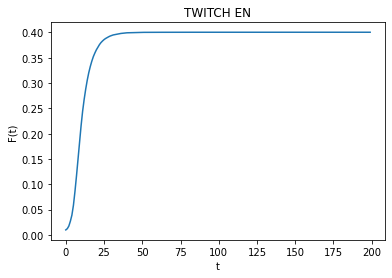

Beta: 0.005900017098483644
Gamma: 0.062022489519257144


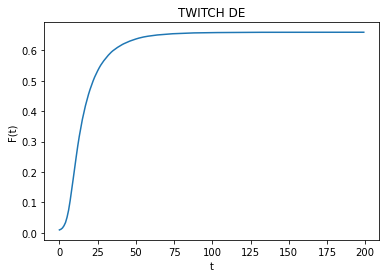

In [92]:
# ---------- Simulate & Plot the values (EN) ----------
x, y = simulate(G_TWITCH_EN, p=0.01, num_of_simulations=10, show_bar=False)
plot_values(x, y, "TWITCH EN")

# ---------- Simulate & Plot the values (DE) ----------
x, y = simulate(G_TWITCH_DE, p=0.01, num_of_simulations=10, show_bar=False)
plot_values(x, y, "TWITCH DE")


<k>: 27.696969696969695
bth = 0.026566678293221718
beta = 1.5 * bth = 0.039850017439832575
gamma = beta / lambda (1.25) = 0.03188001395186606
p = 0.02
Beta: 0.039850017439832575
Gamma: 0.03188001395186606


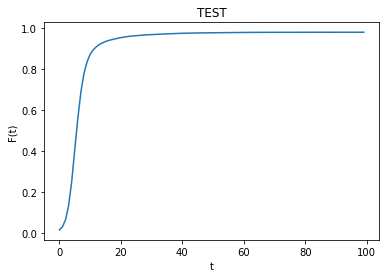

COMPARE PLOT TO FIGURE 2 (PAGE 10) IN PAPER [2]


In [97]:
# -------------------- SECTION DIFFERENT DATASETS --------------------

# !!!!! uncomment the one you want to use and then run !!!!!

# ---------- FACEBOOK ----------
# G = nx.read_gml("dataset/graph_facebook.gml")


# ---------- JAZZ ----------
G = nx.read_gml("dataset/graph_jazz_collab.gml")


# ---------- DOLPHINS ----------
# G = nx.read_gml("dataset/graph_dolphins.gml")



# -------------------- Calculate some numbers in order to get the same parameters as in paper [2] --------------------
n = G.number_of_nodes()
degrees = [v for k,v in G.degree()]
avg_degree = np.mean(degrees)
avg_sqrd_degrees = np.mean([d**2 for d in degrees])

print("<k>: "+str(avg_degree))
bth = get_infection_threshold(G)                          # [2] PAGE 7 (formula for bth) / PAGE 10 table 4 (value for bth)
beta = 1.5 * bth                                          # [2] PAGE 7 (formula for beta)
lamb = 1.25                                               # [2] PAGE 11 figure 2 (ratio infection prob / recovery prob)
p = 0.02                                                  # [2] PAGE 11 figure 2
print("bth = "+str(bth))
print("beta = 1.5 * bth = "+str(beta))
gamma = beta / lamb                                       # [2] PAGE 7 (formula for beta)
print("gamma = beta / lambda (1.25) = "+str(gamma))       # [2] PAGE 11 figure 2: Use ratio of 1.25
print("p = "+str(p))


# ---------- Simulate ----------
x, y = simulate(G, p=p, beta=beta, gamma=gamma, num_of_simulations=100, num_of_t=100, show_bar=False)

# ---------- Plot the values ----------
plot_values(x, y, "TEST")
print("COMPARE PLOT TO FIGURE 2 (PAGE 10) IN PAPER [2]")